In [2]:
import pandas as pd
import numpy as np

In [3]:
import xgboost as xgb

In [4]:
import matplotlib.pyplot as plt
import seaborn as SNS
%matplotlib inline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [251]:
#import daily sales data
sales = pd.read_csv('prophetdf.csv')
sales['ds']=  pd.to_datetime(sales['ds'])
#import prophet prediction
forecast = pd.read_csv('prophet_forecast.csv')
forecast = forecast[['ds', 'trend','yhat','weekly', 'yearly','holidays']]#'yhat_lower', 'yhat_upper'
forecast['ds']=  pd.to_datetime(forecast['ds'])
data = pd.merge(sales,forecast,on='ds',how='left')
#import weather data
weather = pd.read_csv('weather.csv')
weather['ds']=  pd.to_datetime(weather['ds'])
data = pd.merge(data,weather,on='ds',how='left')

In [252]:
#holiday_season(nov 1 - dec 23)
#data['Day'] = data['ds'].dt.day
data['Week'] = data['ds'].dt.week
data['Month'] = data['ds'].dt.month
data['Year'] = data['ds'].dt.year
data['DayofYear'] = data['ds'].dt.dayofyear
data['DayofWeek'] = data['ds'].dt.dayofweek

def holiday_season(x):
    if 305 <= x <= 357:
        return 1
    return 0
data['holiday_season'] = data['DayofYear'] .apply(holiday_season)
#remove outliers and first month to match forecast df
data = data.drop(index=[366,468,774,314,957]) #180, 213
#add offset
data['y1'] = data['y'].shift(1)
#rolling average
data['rolling'] = data['y'].rolling(3).mean()
data = data[30:]
#set date to index
data = data.reset_index(drop=True)

C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\2870461963.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['ds'].dt.week


In [254]:
X.head()

,trend,yhat,weekly,yearly,holidays,temperature,humidity,Week,Month,Year,DayofYear,DayofWeek,holiday_season,y1,rolling
0,38545.692653,27752.361947,0.046416,-0.283143,0.000000,21.1,63.0,27,7,2019,183,1,0,30217.879866,26303.081390
1,38602.770751,26351.251567,0.012112,-0.281103,0.000000,18.8,51.0,27,7,2019,184,2,0,29825.892188,30063.970657
2,38659.848850,24881.133412,-0.027735,-0.277960,0.000000,20.4,54.0,27,7,2019,185,3,0,30148.139918,29620.243518
3,38716.926948,19685.427679,-0.076655,-0.273772,-0.081492,22.0,51.0,27,7,2019,186,4,0,28886.698448,29437.612368
4,38774.005047,19662.916076,-0.146201,-0.268609,-0.013384,25.0,56.0,27,7,2019,187,5,0,29277.998737,26495.176865


In [374]:
model = xgb.XGBRegressor(n_estimators=1000, colsample_bytree =0.4,
 gamma = 0.0,
 learning_rate =  0.05,
 max_depth = 8,
 min_child_weight = 7)


'''colsample_bytree =0.3,
 gamma = 0.0,
 learning_rate =  0.15,
 max_depth = 5,
 min_child_weight = 1'''

'''colsample_bytree =0.4,
 gamma = 0.0,
 learning_rate =  0.05,
 max_depth = 8,
 min_child_weight = 7)'''

'colsample_bytree =0.4,\n gamma = 0.0,\n learning_rate =  0.05,\n max_depth = 8,\n min_child_weight = 7)'

In [428]:
#split x / y and train / test
X = data.drop(columns = ['ds','y', 'condition', 'condition_severity'])#'stringency_index','y1'
y =  data['y']
value = 7
X_train = X[:-value]
X_test = X[-value:]
y_train = y[:-value]
y_test = y[-value:]

In [429]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [170]:
#y_pred = model.predict(X_test)

In [430]:
y_pred = []
for x in range(len(X_test)):
    test = X_test[x:x+1]
    #test = scaler.transform(test)
    pred = model.predict(test)
    X_test['y1'][x+len(X_train)+1] = float(pred) 
    y_pred.append(float(pred))
    if x == 0:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
    if x == 1:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-1]+float(pred)+X_test['y1'][x+len(X_train)])/3 
    if x > 1:
        X_test['rolling'][x+len(X_train)+1] = (float(pred)+X_test['y1'][x+len(X_train)]+X_test['y1'][x+len(X_train)-1])/3
        


C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\631629252.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y1'][x+len(X_train)+1] = float(pred)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\631629252.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\631629252.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [406]:
X_test

,trend,yhat,weekly,yearly,holidays,temperature,humidity,Week,Month,Year,DayofYear,DayofWeek,holiday_season,y1,rolling
916,110042.402096,92336.166190,-0.076655,-0.129396,0.0,-0.3,75.0,1,1,2022,7,4,0,101522.795968,100679.833632
917,110133.247810,86488.490437,-0.146201,-0.115573,0.0,0.4,79.0,1,1,2022,8,5,0,96945.882812,100929.752937
918,110224.093524,111505.839894,0.070705,-0.101365,0.0,2.7,82.0,1,1,2022,9,6,0,97354.570312,98607.749698
919,110314.939239,120255.810771,0.121358,-0.087071,0.0,0.1,86.0,2,1,2022,10,0,0,100769.820312,98356.757812
920,110405.784953,114020.444934,0.046416,-0.072975,0.0,-1.2,85.0,2,1,2022,11,1,0,105915.195312,101346.528646
921,110496.630667,110891.933417,0.012112,-0.059352,0.0,-1.6,76.0,2,1,2022,12,2,0,99147.890625,101944.302083
922,110587.476381,107666.975524,-0.027735,-0.046457,0.0,0.2,79.0,2,1,2022,13,3,0,98200.421875,101087.835938


In [313]:
X.tail(7)

,trend,yhat,weekly,yearly,holidays,temperature,humidity,Week,Month,Year,DayofYear,DayofWeek,holiday_season,y1,rolling
916,110042.402096,92336.166190,-0.076655,-0.129396,0.0,-0.3,75.0,1,1,2022,7,4,0,101522.795968,100679.833632
917,110133.247810,86488.490437,-0.146201,-0.115573,0.0,0.4,79.0,1,1,2022,8,5,0,96945.882812,96821.061404
918,110224.093524,111505.839894,0.070705,-0.101365,0.0,2.7,82.0,1,1,2022,9,6,0,97354.570312,96723.029423
919,110314.939239,120255.810771,0.121358,-0.087071,0.0,0.1,86.0,2,1,2022,10,0,0,100769.820312,100345.810403
920,110405.784953,114020.444934,0.046416,-0.072975,0.0,-1.2,85.0,2,1,2022,11,1,0,105915.195312,106330.680760
921,110496.630667,110891.933417,0.012112,-0.059352,0.0,-1.6,76.0,2,1,2022,12,2,0,99147.890625,106088.820074
922,110587.476381,107666.975524,-0.027735,-0.046457,0.0,0.2,79.0,2,1,2022,13,3,0,98200.421875,102926.010743


In [431]:
print('rmse model:', np.sqrt(mean_squared_error(y_test,y_pred)))
print('rmse prophet:', np.sqrt(mean_squared_error(y_test,X_test['yhat'])))
print('rmse avg:', np.sqrt(mean_squared_error(y_test,(X_test['yhat']+y_pred)/2)))
results = pd.DataFrame()
results['actual'] = y_test
results['prediction'] = y_pred
results['prophet'] = X_test['yhat']
results['average'] = (X_test['yhat']+y_pred)/2
results

rmse model: 4831.184020071744
rmse prophet: 8899.8588135311
rmse avg: 4083.7924675340223


,actual,prediction,prophet,average
916,96196.124898,96945.882812,92336.166190,94641.024501
917,92744.263348,97354.570312,86488.490437,91921.530375
918,101228.700023,100769.820312,111505.839894,106137.830103
919,107064.467839,105915.195312,120255.810771,113085.503042
920,110698.874419,99147.890625,114020.444934,106584.167779
921,100503.117963,98200.421875,110891.933417,104546.177646
922,97576.039846,96433.117188,107666.975524,102050.046356


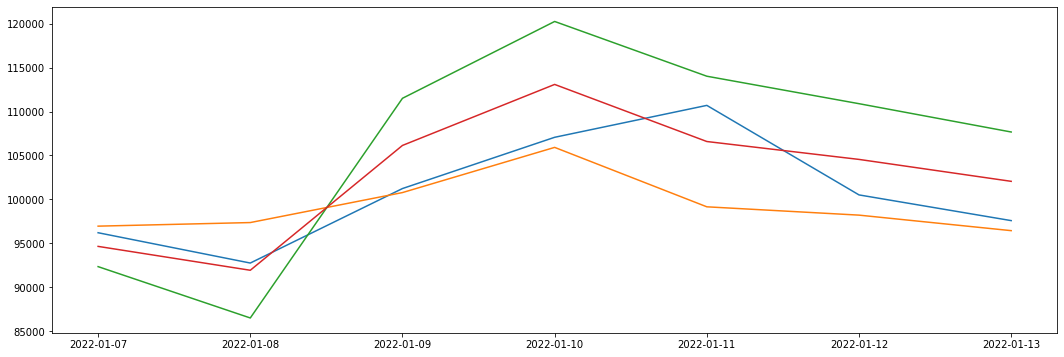

In [432]:
results['ds'] = pd.to_datetime(data['ds'][-value:])
results = results.set_index('ds')
plt.figure(figsize=(18, 6))
plt.plot(results)

In [433]:
#split x / y and train / test
X = data.drop(columns = ['ds','y', 'condition', 'condition_severity'])#'stringency_index',
y =  data['y']
X_train = X[:-23]
X_test = X[-23:-16]
y_train = y[:-23]
y_test = y[-23:-16]
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [174]:
#y_pred = model.predict(X_test)

In [434]:
y_pred = []
for x in range(len(X_test)):
    test = X_test[x:x+1]
    #test = scaler.transform(test)
    pred = model.predict(test)
    X_test['y1'][x+len(X_train)+1] = float(pred) 
    y_pred.append(float(pred))
    if x == 0:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
    if x == 1:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-1]+float(pred)+X_test['y1'][x+len(X_train)])/3 
    if x > 1:
        X_test['rolling'][x+len(X_train)+1] = (float(pred)+X_test['y1'][x+len(X_train)]+X_test['y1'][x+len(X_train)-1])/3
        
        

C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\3883599421.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y1'][x+len(X_train)+1] = float(pred)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\3883599421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\3883599421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [435]:
print('rmse model:', np.sqrt(mean_squared_error(y_test,y_pred)))
print('rmse prophet:', np.sqrt(mean_squared_error(y_test,X_test['yhat'])))
print('rmse avg:', np.sqrt(mean_squared_error(y_test,(X_test['yhat']+y_pred)/2)))
results = pd.DataFrame()
results['actual'] = y_test
results['prediction'] = y_pred
results['prophet'] = X_test['yhat']
results['average'] = (X_test['yhat']+y_pred)/2
results

rmse model: 14610.865768970229
rmse prophet: 16215.123390045326
rmse avg: 14032.131069597315


,actual,prediction,prophet,average
900,74357.172142,86466.023438,104409.641883,95437.832660
901,74029.801498,87379.718750,97574.491696,92477.105223
902,59059.391196,76778.367188,66859.178566,71818.772877
903,84937.096045,73356.375000,78819.303672,76087.839336
904,95617.620952,92744.648438,109799.560751,101272.104594
905,118019.757473,97397.265625,110350.702494,103873.984059
906,106367.443052,89400.390625,101387.249825,95393.820225


In [421]:
#split x / y and train / test
X = data.drop(columns = ['ds','y', 'condition', 'condition_severity'])#'stringency_index',
y =  data['y']
value = 20
X_train = X[:-value]
X_test = X[-value:]
y_train = y[:-value]
y_test = y[-value:]
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [215]:
#y_pred = model.predict(X_test)

In [422]:
y_pred = []
for x in range(len(X_test)):
    test = X_test[x:x+1]
    #test = scaler.transform(test)
    pred = model.predict(test)
    X_test['y1'][x+len(X_train)+1] = float(pred) 
    y_pred.append(float(pred))
    if x == 0:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
    if x == 1:
        X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-1]+float(pred)+X_test['y1'][x+len(X_train)])/3 
    if x > 1:
        X_test['rolling'][x+len(X_train)+1] = (float(pred)+X_test['y1'][x+len(X_train)]+X_test['y1'][x+len(X_train)-1])/3


C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\822862501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y1'][x+len(X_train)+1] = float(pred)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\822862501.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['rolling'][x+len(X_train)+1] = (y_train[len(y_train)-2]+y_train[len(y_train)-1]+float(pred))/3
C:\Users\Alex\AppData\Local\Temp\ipykernel_30044\822862501.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [427]:
print('rmse model:', np.sqrt(mean_squared_error(y_test,y_pred)))
print('rmse prophet:', np.sqrt(mean_squared_error(y_test,X_test['yhat'])))
print('rmse avg:', np.sqrt(mean_squared_error(y_test,(X_test['yhat']+y_pred)/2)))
results = pd.DataFrame()
results['actual'] = y_test
results['prediction'] = y_pred
results['prophet'] = X_test['yhat']
results['average'] = (X_test['yhat']+y_pred)/2
results

rmse model: 19390.372290599968
rmse prophet: 8951.251345911562
rmse avg: 11251.426087404567


,actual,prediction,prophet,average
903,84937.096045,63992.468750,78819.303672,71405.886211
904,95617.620952,83104.984375,109799.560751,96452.272563
905,118019.757473,84879.625000,110350.702494,97615.163747
906,106367.443052,79877.617188,101387.249825,90632.433506
907,110688.021437,86833.312500,94593.362620,90713.337560
908,82701.836914,82408.359375,88208.154213,85308.256794
909,44111.592040,65594.953125,61464.541146,63529.747135
910,54104.788051,54318.250000,53936.340778,54127.295389
911,93466.279742,80450.781250,100008.200932,90229.491091
912,102294.937063,82517.859375,104697.176710,93607.518042


In [426]:
print('rmse avg:', np.sqrt(mean_squared_error(y_test,(X_test['yhat']+y_pred)/2)))

rmse avg: 11251.426087404567


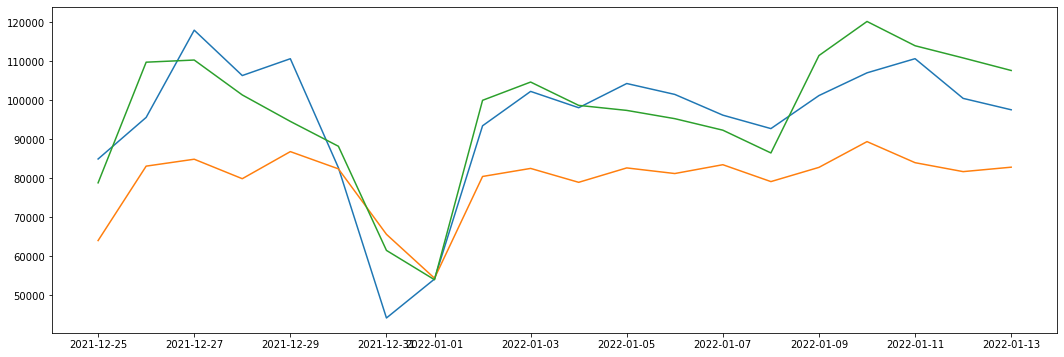

In [424]:
results['ds'] = pd.to_datetime(data['ds'][-value:])
results = results.set_index('ds')
plt.figure(figsize=(18, 6))
plt.plot(results)

In [372]:
value = 30
X_train = X[:-value]
X_test = X[-value:]
y_train = y[:-value]
y_test = y[-value:]
param_grid={"learning_rate": (0.05, 0.10, 0.15, 0.2),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[0.2, 0.3, 0.4],}
gs = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid,
            cv=3, scoring='neg_mean_squared_error',  n_jobs=-1)
gs.fit(X_train,y_train)
gs.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 7}

In [373]:
value = 7
X_train = X[:-value]
X_test = X[-value:]
y_train = y[:-value]
y_test = y[-value:]
param_grid={"learning_rate": (0.05, 0.10, 0.15, 0.2),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[0.2, 0.3, 0.4],}
gs = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid,
            cv=3, scoring='neg_mean_squared_error',  n_jobs=-1)
gs.fit(X_train,y_train)
gs.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 7}